In [57]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import math

import torch
import matplotlib.pyplot as plt
from einops import rearrange
from typing import Union, Dict, Optional
from torch import Tensor, nn
from torch.distributions import Categorical, Normal
from torch.nn import functional as F

from bliss.catalog import TileCatalog, get_images_in_tiles, get_is_on_from_n_sources
from bliss.reporting import DetectionMetrics
from case_studies.psf_homogenization.psf_decoder import PsfSampler, GalsimBlenswithPSF
from bliss.models.detection_encoder import (
    LogBackgroundTransform,
    ConcatBackgroundTransform,
    EncoderCNN,
    make_enc_final,
)


# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

5


In [58]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])

In [72]:
# set up test data
prior = instantiate(cfg.datasets.galsim_blended_galaxies_psf.prior) 
decoder = instantiate(cfg.datasets.galsim_blended_galaxies_psf.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 10000
n_batches = 1
psf_sampler = PsfSampler(0.5, 1.2)

ds_psf = GalsimBlenswithPSF(prior, decoder, background, tile_slen, max_tile_n_sources, num_workers=0, batch_size=5, n_batches=1, psf_sampler=psf_sampler, std_psf_fwhm=1.0, valid_n_batches=1)



torch.Size([5, 1, 88, 88])
torch.Size([5, 1, 88, 88])



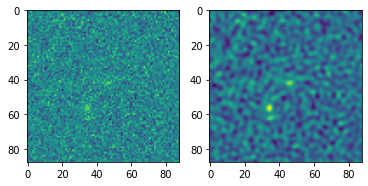

In [73]:
for x in ds_psf.train_dataloader():
    print(x["images"].shape)
    print(x["noisy_image"].shape)
    print()
    plt.figure()
    plt.subplot(121)
    plt.imshow(x['noisy_image'][0, 0].numpy())
    plt.subplot(122)
    plt.imshow(x["images"][0, 0].numpy())
    plt.show()
plt.close()

In [61]:
# load checkpoint
model_checkpoint = torch.load("/home/wangchv/bliss/case_studies/psf_homogenization/output/sdss_detection_encoder_full_decoder_homo/version_0/checkpoints/epoch=989-val_loss=-0.014.ckpt")



In [62]:
# which weight should we use?
model_checkpoint.keys()
model_checkpoint["state_dict"]#["enc_conv.layer.989.weight"]


OrderedDict([('n_detections_map',
              tensor([[1],
                      [0]], device='cuda:0')),
             ('enc_conv.layer.0.weight',
              tensor([[[[ 0.1601,  0.1946, -0.0442],
                        [ 0.2306,  0.0083,  0.0703],
                        [-0.0957,  0.1557,  0.2022]],
              
                       [[-0.1646,  0.2229,  0.0640],
                        [ 0.1727,  0.0322,  0.1363],
                        [-0.0216,  0.2059,  0.0581]]],
              
              
                      [[[-0.1617,  0.0604, -0.1654],
                        [-0.0276, -0.0708,  0.1410],
                        [-0.1913, -0.0906, -0.0823]],
              
                       [[-0.1656,  0.0225, -0.2289],
                        [ 0.1803, -0.2012,  0.2034],
                        [ 0.0151, -0.0763,  0.1493]]],
              
              
                      [[[ 0.0175,  0.1722,  0.0335],
                        [-0.0669,  0.0588, -0.0587],
             

In [63]:
# set up functions for test
n_bands = 1
tile_slen = 4
ptile_slen = 52
mean_detection = 0.03
max_detection = 1
channel = 8
spatial_dropout = 0.0
hidden = 128
dropout = 0.0

def dist_param_groups():
        return {
            "loc_mean": {"dim": 2},
            "loc_logvar": {"dim": 2},
            "log_flux_mean": {"dim": n_bands},
            "log_flux_logvar": {"dim": n_bands},
        }

n_params_per_source = sum(param["dim"] for param in dist_param_groups().values())
n_total_detections = max_detection * (max_detection + 1) // 2
n_source_params = n_total_detections * n_params_per_source
count_simplex_dim = 1 + max_detection
dim_out_all = n_source_params + count_simplex_dim
dim_enc_conv_out = ((ptile_slen + 1) // 2 + 1) // 2

input_transform = ConcatBackgroundTransform()
n_bands_in = input_transform.output_channels(n_bands)
enc_conv = EncoderCNN(n_bands_in, channel, spatial_dropout)

enc_final = make_enc_final(
    channel * 4 * dim_enc_conv_out ** 2,
    hidden,
    dim_out_all,
    dropout,
)
log_softmax = nn.LogSoftmax(dim=1)

md, ntd = max_detection, n_total_detections
n_detections_map = torch.full((md + 1, md), ntd, device="cuda:0")


In [64]:
def encoder(image_ptiles: Tensor) -> Dict[str, Tensor]:
    transformed_ptiles = input_transform(image_ptiles)
    enc_conv_output = enc_conv(transformed_ptiles)
    enc_final_output = enc_final(enc_conv_output)

    dim_out_all = enc_final_output.shape[1]
    dim_per_source_params = dim_out_all - (max_detection + 1)
    per_source_params, n_source_free_probs = torch.split(
        enc_final_output, (dim_per_source_params, max_detection + 1), dim=1
    )
    per_source_params = rearrange(
        per_source_params,
        "n_ptiles (td pps) -> n_ptiles td pps",
        td=n_total_detections,
        pps=n_params_per_source,
    )

    n_source_log_probs = log_softmax(n_source_free_probs)

    return {
        "per_source_params": per_source_params,
        "n_source_log_probs": n_source_log_probs,
    }

In [65]:
def encode_for_n_sources(
        params_per_source: Tensor, tile_n_sources: Tensor
    ) -> Dict[str, Tensor]:
        """Get distributional parameters conditioned on number of sources in tile.
        Args:
            params_per_source: An output of `self.encode(ptiles)`,
                Has size `(batch_size x n_tiles_h x n_tiles_w) * d`.
            tile_n_sources:
                A tensor of the number of sources in each tile.
        Returns:
            A dictionary where each member has shape
            `n_samples x n_ptiles x max_detections x ...`
        """
        assert tile_n_sources.max() <= max_detection

        # first, we transform `tile_n_sources` so that it can be used as an index
        # for looking up detections in `params_per_source`
        sindx1 = n_detections_map[tile_n_sources]  # type: ignore
        sindx2 = rearrange(sindx1, "ns np md -> np (ns md) 1")
        sindx3 = sindx2.expand(sindx2.size(0), sindx2.size(1), n_params_per_source)

        # next, we pad `params_per_source` with a dummy column of zeros that will be looked up
        # (copied) whenever fewer the `max_detections` sources are present. `gather` does the copy.
        pps_padded = F.pad(params_per_source, (0, 0, 0, 1))
        pps_gathered = torch.gather(pps_padded, 1, sindx3)
        params_n_srcs_combined = rearrange(
            pps_gathered, "np (ns md) pps -> ns np md pps", ns=tile_n_sources.size(0)
        )

        # finally, we slice pps5 by parameter group because these groups are treated differently,
        # subsequently
        split_sizes = [v["dim"] for v in dist_param_groups().values()]
        dist_params_split = torch.split(params_n_srcs_combined, split_sizes, 3)
        names = dist_param_groups().keys()
        params_n_srcs = dict(zip(names, dist_params_split))

        # I don't think the special case for `x == 0` should be necessary
        loc_mean_func = lambda x: torch.sigmoid(x) * (x != 0).float()
        params_n_srcs["loc_mean"] = loc_mean_func(params_n_srcs["loc_mean"])

        params_n_srcs["loc_sd"] = (params_n_srcs["loc_logvar"].exp() + 1e-5).sqrt()
        params_n_srcs["log_flux_sd"] = (params_n_srcs["log_flux_logvar"].exp() + 1e-5).sqrt()

        # delete these so we don't accidentally use them
        del params_n_srcs["loc_logvar"]
        del params_n_srcs["log_flux_logvar"]

        return params_n_srcs

In [66]:
def sample(
        dist_params: Dict[str, Tensor],
        n_samples: Union[int, None],
        n_source_weights: Optional[Tensor] = None,
    ) -> Dict[str, Tensor]:
        """Sample from the encoded variational distribution.
        Args:
            dist_params: The output of `self.encode(image_ptiles)`,
                which is the distributional parameters in matrix form.
            n_samples:
                The number of samples to draw. If None, the variational mode is taken instead.
            n_source_weights:
                If specified, adjusts the sampling probabilities of n_sources.
        Returns:
            A dictionary of tensors with shape `n_samples * n_ptiles * max_sources * ...`.
            Consists of `"n_sources", "locs", "log_fluxes", and "fluxes"`.
        """
        if n_source_weights is None:
            n_source_weights = torch.ones(max_detection + 1, device="cuda:0")
        n_source_weights = n_source_weights.reshape(1, -1)
        ns_log_probs_adj = dist_params["n_source_log_probs"] + n_source_weights.log()
        ns_log_probs_adj -= ns_log_probs_adj.logsumexp(dim=-1, keepdim=True)

        if n_samples is not None:
            n_source_probs = ns_log_probs_adj.exp()
            tile_n_sources = Categorical(probs=n_source_probs).sample((n_samples,))
        else:
            tile_n_sources = torch.argmax(ns_log_probs_adj, dim=-1).unsqueeze(0)
        # get distributional parameters conditioned on the sampled numbers of light sources
        dist_params_n_src = encode_for_n_sources(
            dist_params["per_source_params"], tile_n_sources
        )

        tile_is_on_array = get_is_on_from_n_sources(tile_n_sources, max_detection)
        tile_is_on_array = tile_is_on_array.unsqueeze(-1)

        if n_samples is not None:
            tile_locs = Normal(dist_params_n_src["loc_mean"], dist_params_n_src["loc_sd"]).rsample()
            tile_log_fluxes = Normal(
                dist_params_n_src["log_flux_mean"], dist_params_n_src["log_flux_sd"]
            ).rsample()
        else:
            tile_locs = dist_params_n_src["loc_mean"]
            tile_log_fluxes = dist_params_n_src["log_flux_mean"]
        tile_locs *= tile_is_on_array  # Is masking here helpful/necessary?
        tile_fluxes = tile_log_fluxes.exp()
        tile_fluxes *= tile_is_on_array

        return {
            "locs": tile_locs,
            "log_fluxes": tile_log_fluxes,
            "fluxes": tile_fluxes,
            "n_sources": tile_n_sources,
        }

In [67]:
def variational_mode(
        dist_params: Dict[str, Tensor], n_source_weights: Optional[Tensor] = None
    ) -> Dict[str, Tensor]:
        """Compute the variational mode. Special case of sample() where first dim is squeezed."""
        detection_params = sample(dist_params, None, n_source_weights=n_source_weights)
        return {k: v.squeeze(0) for k, v in detection_params.items()}

In [68]:
def test(model, batch):
        """Pytorch lightning method."""
        batch_size = len(batch["images"])
        
        catalog_dict = {
            "locs": batch["locs"][:, :, :, 0 : max_detection],
            "log_fluxes": batch["log_fluxes"][:, :, :, 0 : max_detection],
            "galaxy_bools": batch["galaxy_bools"][:, :, :, 0 : max_detection],
            "n_sources": batch["n_sources"].clamp(max=max_detection),
        }
        true_tile_catalog = TileCatalog(tile_slen, catalog_dict)
        true_full_catalog = true_tile_catalog.to_full_params()
        image_ptiles = get_images_in_tiles(
            torch.cat((batch["images"], batch["background"]), dim=1),
            tile_slen,
            ptile_slen,
        )
        image_ptiles = rearrange(image_ptiles, "n nth ntw b h w -> (n nth ntw) b h w")
        dist_params = encoder(image_ptiles)
        est_catalog_dict = variational_mode(dist_params, model["state_dict"]["enc_conv.layer.0.weight"])
        est_tile_catalog = TileCatalog.from_flat_dict(
            true_tile_catalog.tile_slen,
            true_tile_catalog.n_tiles_h,
            true_tile_catalog.n_tiles_w,
            est_catalog_dict,
        )
        est_full_catalog = est_tile_catalog.to_full_params()

        metrics = DetectionMetrics(true_full_catalog, est_full_catalog)
        return metrics


In [69]:
for x in ds_psf.test_dataloader():
    print(test(model_checkpoint, x))
    

RuntimeError: The size of tensor a (2) must match the size of tensor b (144) at non-singleton dimension 1